In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

In [22]:
# define hyperparameters
batch_size = 64
in_features = 32*32*3
hidden_size = 256
num_classes = 10

device = "cuda"

In [3]:
# load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
val_dataset   = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# build the dataloader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [4]:
image_batch, target_batch = next(iter(train_loader))
print(f"number of batches: {len(train_loader)}")
print(f"image batch shape: {image_batch.shape}")
print(f"target batch shape: {target_batch.shape}")

number of batches: 782
image batch shape: torch.Size([64, 3, 32, 32])
target batch shape: torch.Size([64])


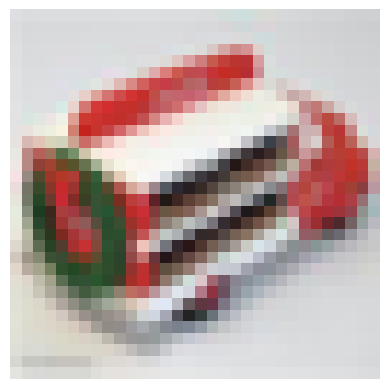

In [11]:
sample_image = image_batch[0]          # (3, 32, 32)
sample_image_npy = sample_image.numpy().transpose(1, 2, 0)  # (32, 32, 3)

plt.imshow(sample_image_npy)
plt.axis("off")
plt.show()


In [12]:
# building the model
class MLP(nn.Module):
  def __init__(self, in_features, hidden_size, num_classes):
    super().__init__()

    self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
    self.linear2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
    self.linear3 = nn.Linear(in_features=hidden_size, out_features=num_classes)

  def forward(self, x):
    out = F.relu(self.linear1(x))
    out = F.relu(self.linear2(out))
    out = self.linear3(out)

    return out

### Training the model with custom SGD

In [32]:
model = MLP(in_features=in_features, hidden_size=hidden_size, num_classes=num_classes).to(device)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of model's learnable paraneters: {num_parameters:,}")

Number of model's learnable paraneters: 855,050


In [33]:
lr = 0.1

In [34]:
# forward pass
x = image_batch.view(image_batch.size(0), -1).to(device)
out = model(x)
loss = F.cross_entropy(out, target_batch.to(device))
print(f"loss: {loss.item():.4f}")

loss: 2.3134


In [35]:
# backward pass
loss.backward()

In [36]:
# optimization (manual SGD)
for p in model.parameters():
    p.data += -lr * p.grad

In [37]:
class SGD:
  def __init__(self, model_parameters, learning_rate):

    self.model_parameters = list(model_parameters)
    self.lr    = learning_rate

  def zero_grad(self):
    for p in self.model_parameters:
      p.grad = None

  def step(self):
    for p in self.model_parameters:
      p.data += -self.lr * p.grad

In [38]:
optimizer = SGD(model.parameters(), lr)

In [39]:
train_loss = []
val_loss = []

for epoch in range(10):
    model.train()
    loss_step = 0.0
    correct = 0
    total = 0

    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        target = target.to(device)
        image = image.view(image.size(0), -1)
        output = model(image)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        loss_step += loss.item()
        train_loss.append(loss.item())

    avg_loss_train = loss_step / len(train_loader)
    accuracy_train = correct / total

    model.eval()
    loss_step_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image = image.to(device)
            target = target.to(device)
            image = image.view(image.size(0), -1)
            output = model(image)
            loss = F.cross_entropy(output, target)

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

            loss_step_val += loss.item()
            val_loss.append(loss.item())

    avg_loss_val = loss_step_val / len(val_loader)
    accuracy_val = correct_val / total_val

    print(f"Epoch {epoch+1}: Train loss: {avg_loss_train:.4f}, Train accuracy: {accuracy_train:.4f}, "
          f"Val loss: {avg_loss_val:.4f}, Val accuracy: {accuracy_val:.4f}")

Epoch 1: Train loss: 1.9283, Train accuracy: 0.2983, Val loss: 1.8248, Val accuracy: 0.3311
Epoch 2: Train loss: 1.7301, Train accuracy: 0.3785, Val loss: 1.8364, Val accuracy: 0.3470
Epoch 3: Train loss: 1.6378, Train accuracy: 0.4150, Val loss: 1.8860, Val accuracy: 0.3658
Epoch 4: Train loss: 1.5763, Train accuracy: 0.4366, Val loss: 1.6504, Val accuracy: 0.4196
Epoch 5: Train loss: 1.5236, Train accuracy: 0.4535, Val loss: 1.7802, Val accuracy: 0.3679
Epoch 6: Train loss: 1.4813, Train accuracy: 0.4722, Val loss: 1.6099, Val accuracy: 0.4241
Epoch 7: Train loss: 1.4465, Train accuracy: 0.4841, Val loss: 1.5319, Val accuracy: 0.4501
Epoch 8: Train loss: 1.4090, Train accuracy: 0.4974, Val loss: 1.6871, Val accuracy: 0.4131
Epoch 9: Train loss: 1.3822, Train accuracy: 0.5055, Val loss: 1.5959, Val accuracy: 0.4234
Epoch 10: Train loss: 1.3508, Train accuracy: 0.5160, Val loss: 1.7012, Val accuracy: 0.4054


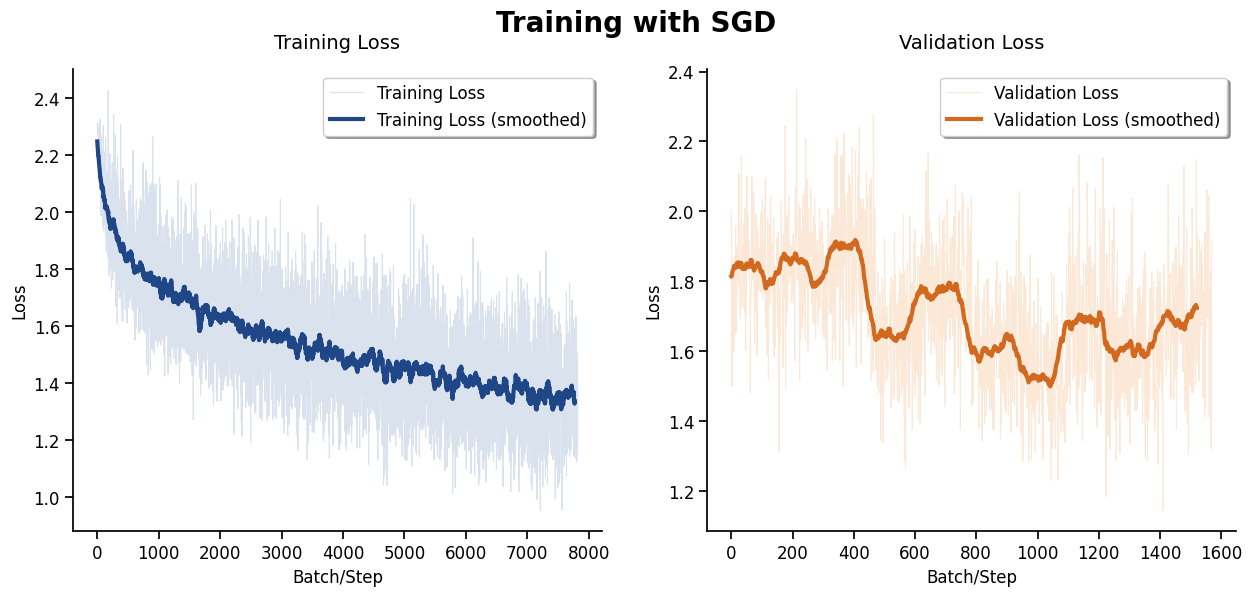

In [40]:
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Main title
fig.suptitle('Training with SGD', fontsize=20, fontweight='bold', family='sans-serif', y=0.98)

# Training loss
window = 50
ax1.plot(train_loss, color='#6C8EBF', alpha=0.25, linewidth=0.8, label='Training Loss')
if len(train_loss) > window:
    train_smooth = np.convolve(train_loss, np.ones(window)/window, mode='valid')
    ax1.plot(train_smooth, color='#1F4788', linewidth=3, label='Training Loss (smoothed)')
ax1.set_xlabel('Batch/Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, pad=15)
ax1.legend(frameon=True, shadow=True, fancybox=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Validation loss
ax2.plot(val_loss, color='#F4A460', alpha=0.25, linewidth=0.8, label='Validation Loss')
if len(val_loss) > window:
    val_smooth = np.convolve(val_loss, np.ones(window)/window, mode='valid')
    ax2.plot(val_smooth, color='#D2691E', linewidth=3, label='Validation Loss (smoothed)')
ax2.set_xlabel('Batch/Step', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss', fontsize=14, pad=15)
ax2.legend(frameon=True, shadow=True, fancybox=True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

### Training the model with custom RMSProp

In [41]:
model = MLP(in_features=in_features, hidden_size=hidden_size, num_classes=num_classes).to(device)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of model's learnable paraneters: {num_parameters:,}")

Number of model's learnable paraneters: 855,050


In [42]:
b = 0.9
lr = 0.001
eps = 1e-8

In [43]:
# forward pass
x = image_batch.view(image_batch.size(0), -1).to(device)
out = model(x)
loss = F.cross_entropy(out, target_batch.to(device))
print(f"loss: {loss.item():.4f}")

loss: 2.3121


In [44]:
# backward
for p in model.parameters():
  p.grad = None
loss.backward()

In [45]:
# defining v for RMSProp
v = {p: torch.zeros_like(p.data) for p in model.parameters()}

In [46]:
for p in model.parameters():
    if p.grad is None:
        continue
    v[p] = (b * v[p]) + ((1 - b) * p.grad**2)
    step = lr / (torch.sqrt(v[p]) + eps) * p.grad
    p.data += -step

In [47]:
class RMSProp:
  def __init__(self, model_parameters, learning_rate, beta=0.9, eps=1e-8):

    self.params = list(model_parameters)
    self.lr = learning_rate
    self.b = beta
    self.eps = eps

    # initialize v
    self.v = [torch.zeros_like(p) for p in self.params]

  def zero_grad(self):
    for p in self.params:
      p.grad = None

  def step(self):
    for i, p in enumerate(self.params):
      self.v[i] = self.b * self.v[i] + (1 - self.b) * (p.grad ** 2)
      step = self.lr * p.grad / (torch.sqrt(self.v[i]) + self.eps)
      p.data -= step

In [48]:
optimizer = RMSProp(model.parameters(), lr)

In [49]:
train_loss = []
val_loss = []

for epoch in range(10):
    model.train()
    loss_step = 0.0
    correct = 0
    total = 0

    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        target = target.to(device)
        image = image.view(image.size(0), -1)
        output = model(image)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        loss_step += loss.item()
        train_loss.append(loss.item())

    avg_loss_train = loss_step / len(train_loader)
    accuracy_train = correct / total

    model.eval()
    loss_step_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image = image.to(device)
            target = target.to(device)
            image = image.view(image.size(0), -1)
            output = model(image)
            loss = F.cross_entropy(output, target)

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

            loss_step_val += loss.item()
            val_loss.append(loss.item())

    avg_loss_val = loss_step_val / len(val_loader)
    accuracy_val = correct_val / total_val

    print(f"Epoch {epoch+1}: Train loss: {avg_loss_train:.4f}, Train accuracy: {accuracy_train:.4f}, "
          f"Val loss: {avg_loss_val:.4f}, Val accuracy: {accuracy_val:.4f}")

Epoch 1: Train loss: 1.9067, Train accuracy: 0.3050, Val loss: 1.8012, Val accuracy: 0.3433
Epoch 2: Train loss: 1.7165, Train accuracy: 0.3846, Val loss: 1.8816, Val accuracy: 0.3459
Epoch 3: Train loss: 1.6232, Train accuracy: 0.4183, Val loss: 1.6566, Val accuracy: 0.4090
Epoch 4: Train loss: 1.5695, Train accuracy: 0.4397, Val loss: 1.6100, Val accuracy: 0.4279
Epoch 5: Train loss: 1.5287, Train accuracy: 0.4565, Val loss: 1.6948, Val accuracy: 0.4165
Epoch 6: Train loss: 1.4995, Train accuracy: 0.4664, Val loss: 1.6533, Val accuracy: 0.4215
Epoch 7: Train loss: 1.4740, Train accuracy: 0.4773, Val loss: 1.6108, Val accuracy: 0.4501
Epoch 8: Train loss: 1.4512, Train accuracy: 0.4823, Val loss: 1.8539, Val accuracy: 0.3884
Epoch 9: Train loss: 1.4344, Train accuracy: 0.4915, Val loss: 1.7259, Val accuracy: 0.4053
Epoch 10: Train loss: 1.4201, Train accuracy: 0.4952, Val loss: 1.6106, Val accuracy: 0.4379


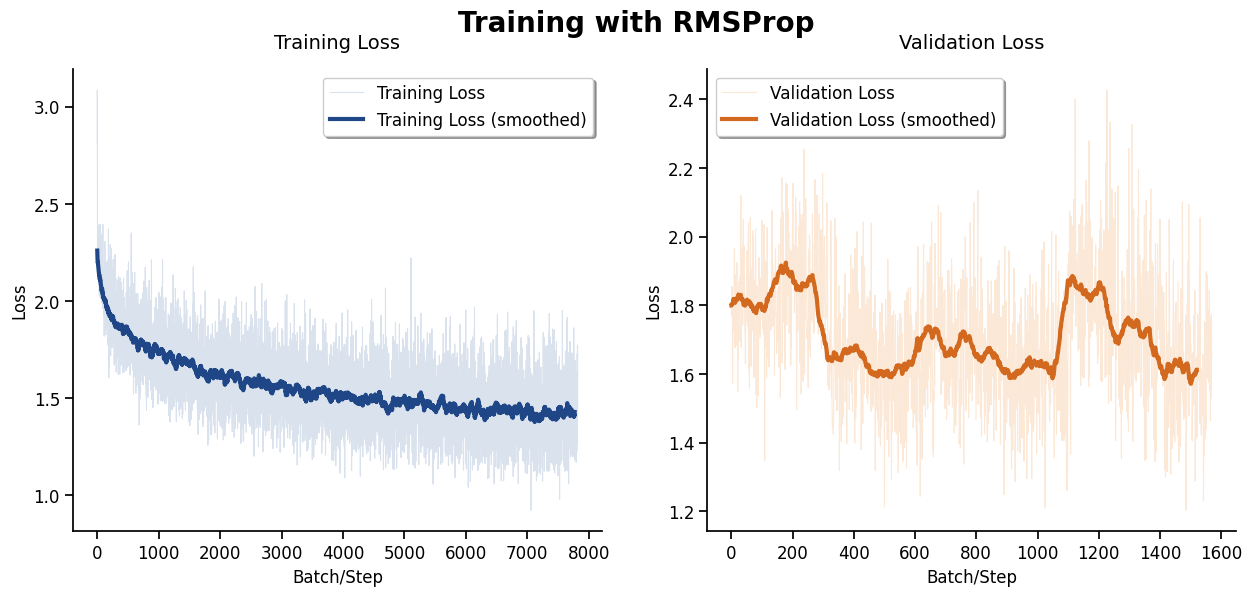

In [50]:
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Main title
fig.suptitle('Training with RMSProp', fontsize=20, fontweight='bold', family='sans-serif', y=0.98)

# Training loss
window = 50
ax1.plot(train_loss, color='#6C8EBF', alpha=0.25, linewidth=0.8, label='Training Loss')
if len(train_loss) > window:
    train_smooth = np.convolve(train_loss, np.ones(window)/window, mode='valid')
    ax1.plot(train_smooth, color='#1F4788', linewidth=3, label='Training Loss (smoothed)')
ax1.set_xlabel('Batch/Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, pad=15)
ax1.legend(frameon=True, shadow=True, fancybox=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Validation loss
ax2.plot(val_loss, color='#F4A460', alpha=0.25, linewidth=0.8, label='Validation Loss')
if len(val_loss) > window:
    val_smooth = np.convolve(val_loss, np.ones(window)/window, mode='valid')
    ax2.plot(val_smooth, color='#D2691E', linewidth=3, label='Validation Loss (smoothed)')
ax2.set_xlabel('Batch/Step', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss', fontsize=14, pad=15)
ax2.legend(frameon=True, shadow=True, fancybox=True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

### Training with custom Adam optimizer

In [51]:
model = MLP(in_features=in_features, hidden_size=hidden_size, num_classes=num_classes).to(device)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of model's learnable paraneters: {num_parameters:,}")

Number of model's learnable paraneters: 855,050


In [52]:
lr = 0.001
b1 = 0.9
b2 = 0.999
eps = 1e-8

In [53]:
x = image_batch.view(image_batch.size(0), -1).to(device)
out = model(x)
loss = F.cross_entropy(out, target_batch.to(device))
print(f"loss: {loss.item():.4f}")

loss: 2.2997


In [54]:
loss.backward()

In [55]:
# define v and m
m = [torch.zeros_like(p.data) for p in model.parameters()]
v = [torch.zeros_like(p.data) for p in model.parameters()]

In [56]:
t = 1
for i, p in enumerate(model.parameters()):
  m[i] = b1 * m[i] + (1 - b1) * p.grad
  v[i] = b2 * v[i] + (1 - b2) * p.grad**2
  m_hat = m[i] / (1 - b1**t)
  v_hat = v[i] / (1 - b2**t)
  step = lr * m_hat / (torch.sqrt(v_hat) + eps)
  p.data -= step

In [57]:
class Adam:
  def __init__(self, model_parameters, learning_rate, beta1=0.9, beta2=0.999, eps=1e-8):

    self.params = list(model_parameters)
    self.lr = learning_rate
    self.b1 = beta1
    self.b2 = beta2
    self.eps = eps

    # define m and v
    self.m = [torch.zeros_like(p.data) for p in self.params]
    self.v = [torch.zeros_like(p.data) for p in self.params]

    # define t for bias correction
    self.t = 0

  def zero_grad(self):
    for p in self.params:
      p.grad = None

  def step(self):
    self.t += 1
    for i, p in enumerate(self.params):
      # calculate m and v of the param
      self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
      self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * p.grad**2
      # bias correction
      m_hat = self.m[i] / (1 - self.b1 ** self.t)
      v_hat = self.v[i] / (1 - self.b2 ** self.t)
      # updating param
      step = self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
      p.data -= step

In [58]:
optimizer = Adam(model.parameters(), lr)

In [59]:
train_loss = []
val_loss = []

for epoch in range(10):
    model.train()
    loss_step = 0.0
    correct = 0
    total = 0

    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        target = target.to(device)
        image = image.view(image.size(0), -1)
        output = model(image)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        loss_step += loss.item()
        train_loss.append(loss.item())

    avg_loss_train = loss_step / len(train_loader)
    accuracy_train = correct / total

    model.eval()
    loss_step_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image = image.to(device)
            target = target.to(device)
            image = image.view(image.size(0), -1)
            output = model(image)
            loss = F.cross_entropy(output, target)

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

            loss_step_val += loss.item()
            val_loss.append(loss.item())

    avg_loss_val = loss_step_val / len(val_loader)
    accuracy_val = correct_val / total_val

    print(f"Epoch {epoch+1}: Train loss: {avg_loss_train:.4f}, Train accuracy: {accuracy_train:.4f}, "
          f"Val loss: {avg_loss_val:.4f}, Val accuracy: {accuracy_val:.4f}")

Epoch 1: Train loss: 1.8391, Train accuracy: 0.3303, Val loss: 1.7003, Val accuracy: 0.3882
Epoch 2: Train loss: 1.6592, Train accuracy: 0.4053, Val loss: 1.6001, Val accuracy: 0.4316
Epoch 3: Train loss: 1.5679, Train accuracy: 0.4412, Val loss: 1.5337, Val accuracy: 0.4456
Epoch 4: Train loss: 1.5142, Train accuracy: 0.4579, Val loss: 1.5052, Val accuracy: 0.4639
Epoch 5: Train loss: 1.4790, Train accuracy: 0.4716, Val loss: 1.4865, Val accuracy: 0.4688
Epoch 6: Train loss: 1.4483, Train accuracy: 0.4819, Val loss: 1.4465, Val accuracy: 0.4812
Epoch 7: Train loss: 1.4212, Train accuracy: 0.4924, Val loss: 1.4381, Val accuracy: 0.4849
Epoch 8: Train loss: 1.3940, Train accuracy: 0.5021, Val loss: 1.4671, Val accuracy: 0.4800
Epoch 9: Train loss: 1.3694, Train accuracy: 0.5131, Val loss: 1.4079, Val accuracy: 0.4991
Epoch 10: Train loss: 1.3474, Train accuracy: 0.5184, Val loss: 1.4086, Val accuracy: 0.4993


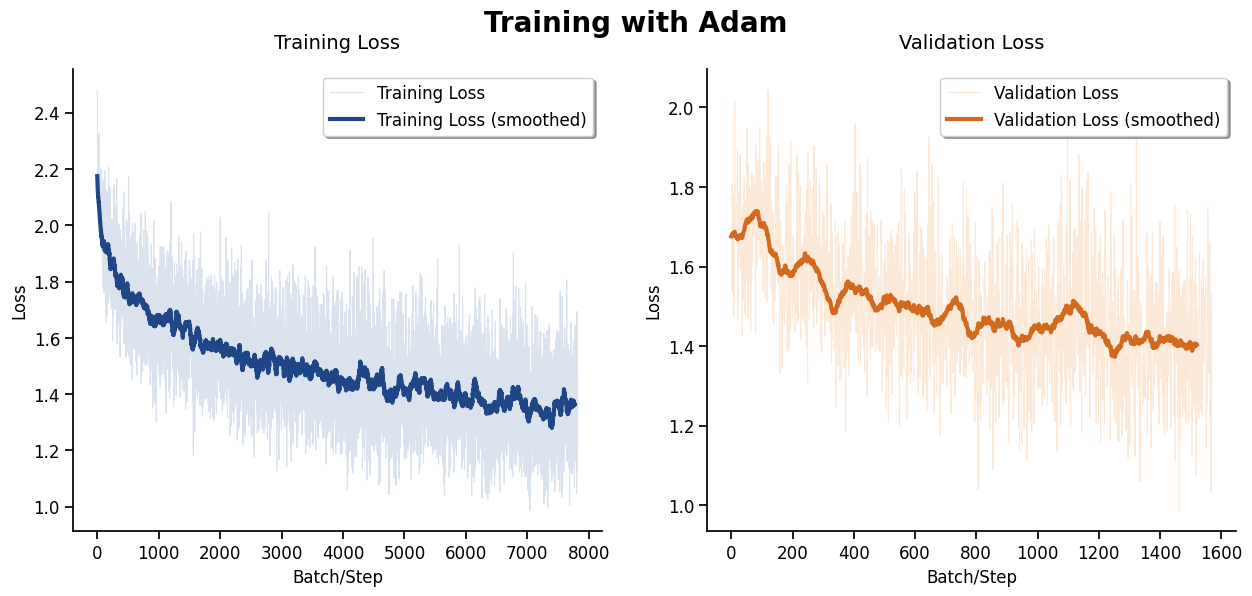

In [60]:
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Main title
fig.suptitle('Training with Adam', fontsize=20, fontweight='bold', family='sans-serif', y=0.98)

# Training loss
window = 50
ax1.plot(train_loss, color='#6C8EBF', alpha=0.25, linewidth=0.8, label='Training Loss')
if len(train_loss) > window:
    train_smooth = np.convolve(train_loss, np.ones(window)/window, mode='valid')
    ax1.plot(train_smooth, color='#1F4788', linewidth=3, label='Training Loss (smoothed)')
ax1.set_xlabel('Batch/Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, pad=15)
ax1.legend(frameon=True, shadow=True, fancybox=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Validation loss
ax2.plot(val_loss, color='#F4A460', alpha=0.25, linewidth=0.8, label='Validation Loss')
if len(val_loss) > window:
    val_smooth = np.convolve(val_loss, np.ones(window)/window, mode='valid')
    ax2.plot(val_smooth, color='#D2691E', linewidth=3, label='Validation Loss (smoothed)')
ax2.set_xlabel('Batch/Step', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss', fontsize=14, pad=15)
ax2.legend(frameon=True, shadow=True, fancybox=True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

### Training with custom AdamW

In [61]:
model = MLP(in_features=in_features, hidden_size=hidden_size, num_classes=num_classes).to(device)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of model's learnable paraneters: {num_parameters:,}")

Number of model's learnable paraneters: 855,050


In [62]:
lr = 0.001
b1 = 0.9
b2 = 0.999
weight_decay = 0.01
eps = 1e-8

In [63]:
x = image_batch.view(image_batch.size(0), -1).to(device)
out = model(x)
loss = F.cross_entropy(out, target_batch.to(device))
print(f"loss: {loss.item():.4f}")

loss: 2.3192


In [64]:
loss.backward()

In [65]:
# define v and m
m = [torch.zeros_like(p.data) for p in model.parameters()]
v = [torch.zeros_like(p.data) for p in model.parameters()]

In [66]:
t = 1
for i, p in enumerate(model.parameters()):
  m[i] = b1 * m[i] + (1 - b1) * p.grad
  v[i] = b2 * v[i] + (1 - b2) * p.grad**2
  m_hat = m[i] / (1 - b1**t)
  v_hat = v[i] / (1 - b2**t)
  step = lr * m_hat / (torch.sqrt(v_hat) + eps)
  p.data -= step
  p.data -= lr * weight_decay * p.data

In [67]:
class AdamW:
  def __init__(self, model_parameters, learning_rate, beta1=0.9, beta2=0.999, weight_decay=0.01, eps=1e-8):

    self.params = list(model_parameters)
    self.lr = learning_rate
    self.b1 = beta1
    self.b2 = beta2
    self.wd = weight_decay
    self.eps = eps

    # define m and v
    self.m = [torch.zeros_like(p.data) for p in self.params]
    self.v = [torch.zeros_like(p.data) for p in self.params]

    # define t for bias correction
    self.t = 0

  def zero_grad(self):
    for p in self.params:
      p.grad = None

  def step(self):
    self.t += 1
    for i, p in enumerate(self.params):
      # calculate m and v of the param
      self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
      self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * p.grad**2
      # bias correction
      m_hat = self.m[i] / (1 - self.b1 ** self.t)
      v_hat = self.v[i] / (1 - self.b2 ** self.t)
      # updating param
      step = self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
      p.data -= step
      # weight decay
      p.data -= self.lr * self.wd * p.data

In [68]:
optimizer = AdamW(model.parameters(), lr)

In [69]:
train_loss = []
val_loss = []

for epoch in range(10):
    model.train()
    loss_step = 0.0
    correct = 0
    total = 0

    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        target = target.to(device)
        image = image.view(image.size(0), -1)
        output = model(image)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        loss_step += loss.item()
        train_loss.append(loss.item())

    avg_loss_train = loss_step / len(train_loader)
    accuracy_train = correct / total

    model.eval()
    loss_step_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image = image.to(device)
            target = target.to(device)
            image = image.view(image.size(0), -1)
            output = model(image)
            loss = F.cross_entropy(output, target)

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

            loss_step_val += loss.item()
            val_loss.append(loss.item())

    avg_loss_val = loss_step_val / len(val_loader)
    accuracy_val = correct_val / total_val

    print(f"Epoch {epoch+1}: Train loss: {avg_loss_train:.4f}, Train accuracy: {accuracy_train:.4f}, "
          f"Val loss: {avg_loss_val:.4f}, Val accuracy: {accuracy_val:.4f}")

Epoch 1: Train loss: 1.8370, Train accuracy: 0.3316, Val loss: 1.7488, Val accuracy: 0.3724
Epoch 2: Train loss: 1.6628, Train accuracy: 0.4036, Val loss: 1.6301, Val accuracy: 0.4170
Epoch 3: Train loss: 1.5838, Train accuracy: 0.4321, Val loss: 1.5493, Val accuracy: 0.4422
Epoch 4: Train loss: 1.5266, Train accuracy: 0.4541, Val loss: 1.5060, Val accuracy: 0.4620
Epoch 5: Train loss: 1.4970, Train accuracy: 0.4663, Val loss: 1.5050, Val accuracy: 0.4607
Epoch 6: Train loss: 1.4625, Train accuracy: 0.4766, Val loss: 1.4816, Val accuracy: 0.4747
Epoch 7: Train loss: 1.4391, Train accuracy: 0.4856, Val loss: 1.4736, Val accuracy: 0.4737
Epoch 8: Train loss: 1.4199, Train accuracy: 0.4935, Val loss: 1.4940, Val accuracy: 0.4729
Epoch 9: Train loss: 1.3988, Train accuracy: 0.5001, Val loss: 1.4329, Val accuracy: 0.4929
Epoch 10: Train loss: 1.3808, Train accuracy: 0.5098, Val loss: 1.4230, Val accuracy: 0.4936


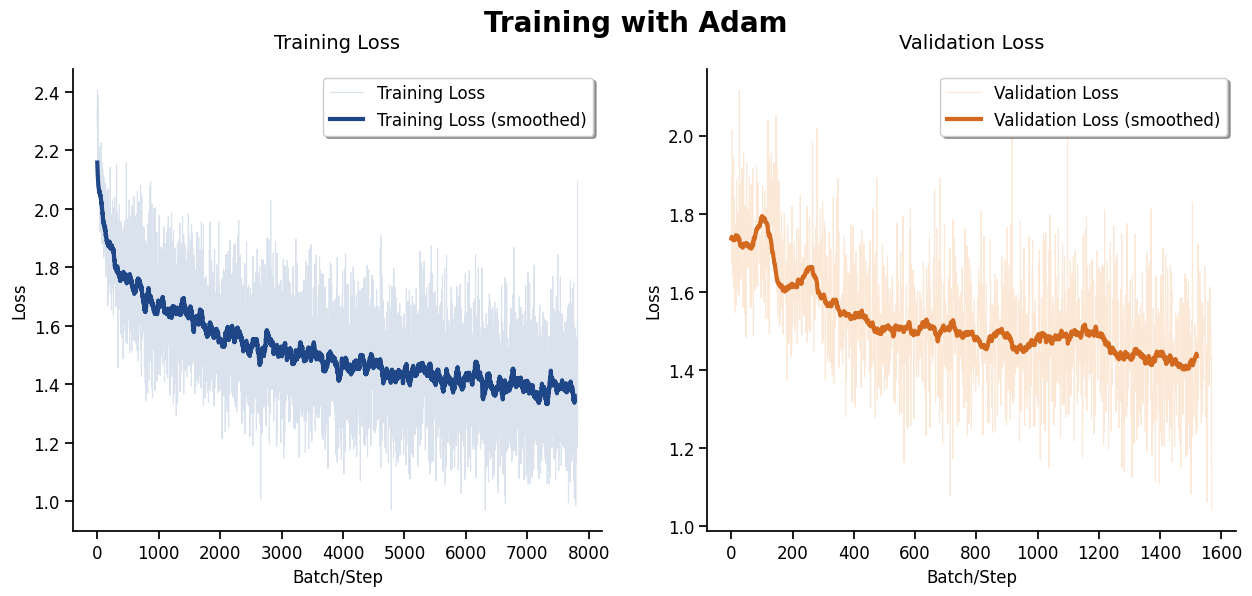

In [70]:
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Main title
fig.suptitle('Training with Adam', fontsize=20, fontweight='bold', family='sans-serif', y=0.98)

# Training loss
window = 50
ax1.plot(train_loss, color='#6C8EBF', alpha=0.25, linewidth=0.8, label='Training Loss')
if len(train_loss) > window:
    train_smooth = np.convolve(train_loss, np.ones(window)/window, mode='valid')
    ax1.plot(train_smooth, color='#1F4788', linewidth=3, label='Training Loss (smoothed)')
ax1.set_xlabel('Batch/Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, pad=15)
ax1.legend(frameon=True, shadow=True, fancybox=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Validation loss
ax2.plot(val_loss, color='#F4A460', alpha=0.25, linewidth=0.8, label='Validation Loss')
if len(val_loss) > window:
    val_smooth = np.convolve(val_loss, np.ones(window)/window, mode='valid')
    ax2.plot(val_smooth, color='#D2691E', linewidth=3, label='Validation Loss (smoothed)')
ax2.set_xlabel('Batch/Step', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Validation Loss', fontsize=14, pad=15)
ax2.legend(frameon=True, shadow=True, fancybox=True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()